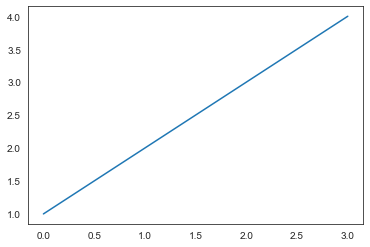

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pprint import pprint
%matplotlib inline
sns.set_style("white")
plt.plot(np.arange(1,5));

In [2]:
# CHECK TUDATASET

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from grakel.datasets import fetch_dataset
from grakel.kernels import ShortestPath

# Loads the MUTAG dataset
MUTAG = fetch_dataset("BZR_MD", verbose=False)
G, y = MUTAG.data, MUTAG.target

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42)

# Uses the shortest path kernel to generate the kernel matrices
gk = ShortestPath(normalize=True)
K_train = gk.fit_transform(G_train)
K_test = gk.transform(G_test)

# Uses the SVM classifier to perform classification
clf = SVC(kernel="precomputed")
clf.fit(K_train, y_train)
y_pred = clf.predict(K_test)

# Computes and prints the classifica◊tion accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", str(round(acc*100, 2)) + "%")

Accuracy: 67.74%


In [3]:
def get_prime_adjacency(dict_, gap_in_prime=0):
    """
    Helper function to create adjacency matrices with primes, using grakel dicts as input.
    Currently we only utilize the edges. The dict has key, values in the form of:
    (head, tail): relation
    :param dict_: dict, The dict has key, values in the form of (head, tail): relation .
    From grakel second argument per graph.
    :return adj: np.array, with the prime-transformed relation numbers
    """
    nodes = set()
    rels = set()
    for key, value in dict_.items():
        nodes.add(key[0])
        nodes.add(key[1])
        rels.add(value)

    nodes = sorted(nodes)
    id2node = {}
    node2id = {}
    for i, n in enumerate(nodes):
        id2node[i] = n
        node2id[n] = i

    rels = sorted(rels)
    from sympy import nextprime
    relid2prime = {}
    prime2relid = {}
    current_int = 2
    for rel in rels:
        cur_prime = nextprime(current_int)
        relid2prime[rel] = cur_prime
        prime2relid[cur_prime] = rel
        current_int = cur_prime + gap_in_prime

    adj = np.zeros((len(nodes), len(nodes)))
    for key, value in dict_.items():
        adj[node2id[key[0]], node2id[key[1]]] = relid2prime[value]
    return adj

prime_adj_all= [get_prime_adjacency(g[2]) for g in  G]
prime_adj_train = [get_prime_adjacency(g[2]) for g in  G_train]
prime_adj_test = [get_prime_adjacency(g[2]) for g in G_test]


In [11]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel, polynomial_kernel, cosine_similarity, chi2_kernel

class ProductPower(TransformerMixin):

    def __init__(self, power=1, use_laplace=True, normalize=False, grakel_compatible=True, kernel='rbf'):
        self.power = power
        self.use_laplace = use_laplace
        self.normalize = normalize
        self.grakel_compatible = grakel_compatible
        self.kernel_str = kernel
        if self.kernel_str == 'rbf':
            self.kernel_fn = rbf_kernel
        elif self.kernel_str == 'linear':
            self.kernel_fn = linear_kernel
        elif self.kernel_str == 'cosine':
            self.kernel_fn = cosine_similarity
        elif self.kernel_str == 'chi2':
            self.kernel_fn = chi2_kernel
        else:
            raise AttributeError(f'Kernel {self.kernel_str} is not understood!')
        self.x_train = None
        self.max_ = 1



        #self.decompose = PCA(n_components='mle')

    def fit(self, X, y=None):
        x_tr = []
        for x in X:
            if self.use_laplace:
                x = laplacian(x)
            try:
                max_array = np.max(x)
            except ValueError:
                # this is for empty adjacency like TOX21_AR
                x_tr.append(np.array([0 for _ in range(self.power)]))
                continue
            if max_array > self.max_:
                self.max_ = max_array
            if self.grakel_compatible:
                n = x.shape[0]
                cur_feat = []
                cur_x = x.copy()
                # Power = 0 (1-hop, original Adjacency)
                cur_prod = np.sum(np.log(cur_x[cur_x >0]))

                if self.normalize:
                    cur_prod = cur_prod / ((n**2)*np.log(self.max_))
                cur_feat.append(cur_prod)
                for p in range(1, self.power):
                    cur_x = np.matmul(cur_x, x)
                    cur_prod = np.sum(np.log(cur_x[cur_x >0]))
                    if self.normalize:
                        cur_prod = cur_prod / ((n**2)*np.log(self.max_**p))
                    cur_prod -= cur_feat[-1]
                    cur_feat.append(cur_prod)
                x_tr.append(np.array(cur_feat))
        if self.grakel_compatible:
            x_tr = np.array(x_tr)
            self.x_train = x_tr#self.kernel_fn(x_tr, x_tr)#x_tr
        #print(self.x_train.shape)
        return self

    def transform(self, X):
        x_tr = []
        for x in X:
            if self.use_laplace:
                x = laplacian(x)
            n = x.shape[0]
            if n == 0:
                x_tr.append(np.array([0 for _ in range(self.power)]))
                continue
            cur_feat = []
            cur_x = x.copy()
            # Power = 0 (1-hop, original Adjacency)
            cur_prod = np.sum(np.log(cur_x[cur_x >0]))
            if self.normalize:
                cur_prod = cur_prod / ((n**2)*np.log(self.max_))
            cur_feat.append(cur_prod)
            for p in range(1, self.power):
                cur_x = np.matmul(cur_x, x)
                cur_prod = np.sum(np.log(cur_x[cur_x >0]))
                if self.normalize:
                    cur_prod = cur_prod / ((n**2)*np.log(self.max_**p))
                cur_prod -= cur_feat[-1]
                cur_feat.append(cur_prod)
            x_tr.append(np.array(cur_feat))
        x_tr = np.array(x_tr)
        if self.grakel_compatible:
            #print('TRANFORM: ', x_tr.shape, self.x_train.shape)
            x_tr_orig = x_tr.copy()
            gamma = 1 / (x_tr.shape[1] * self.x_train.var())
            x_tr = self.kernel_fn(x_tr, self.x_train, gamma=gamma)
            #X_diag = np.einsum('ij,ij->i', self.x_train, self.x_train)
            #Y_diag = np.einsum('ij,ij->i', x_tr_orig, x_tr_orig)
            #print(X_diag.shape, Y_diag.shape)
            #print(np.outer(Y_diag, X_diag).shape)
            #print(x_tr.shape)
            #x_tr /= np.sqrt(np.outer(Y_diag, X_diag))
        return x_tr

from scipy.sparse.csgraph import laplacian

pp = ProductPower(power=3, normalize=False, use_laplace=False, grakel_compatible=True, kernel='rbf')
# Use the graph laplacian
X_train = pp.fit_transform([g for g in prime_adj_train], y_train)
X_test = pp.transform([g for g in prime_adj_test])

# X_train = pp.fit_transform(prime_adj_train, y_train)
# X_test = pp.transform(prime_adj_test)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy PP:", str(round(acc*100, 2)) + "%")

Accuracy PP: 83.87%


In [16]:
pp = ProductPower(power=3, normalize=False, use_laplace=False, grakel_compatible=True, kernel='rbf')

X_train = pp.fit_transform([g for g in [get_prime_adjacency(g[2], gap_in_prime=10000) for g in  G_train]], y_train)
X_test = pp.transform([g for g in [get_prime_adjacency(g[2], gap_in_prime=10000) for g in  G_test]])



# X_train = pp.fit_transform(prime_adj_train, y_train)
# X_test = pp.transform(prime_adj_test)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy PP:", str(round(acc*100, 2)) + "%")

TypeError: linear_kernel() got an unexpected keyword argument 'gamma'

In [5]:
from sklearn.decomposition import TruncatedSVD, IncrementalPCA
from collections import Counter
class Decomposer(TransformerMixin):

    def __init__(self, power=1, n_components=10, use_laplace=True, grakel_compatible=True, kernel='rbf'):
        self.power = power
        self.n_components = n_components
        self.use_laplace = use_laplace
        self.decomposition_method = IncrementalPCA
        self.grakel_compatible = grakel_compatible
        self.kernel_str = kernel
        if self.kernel_str == 'rbf':
            self.kernel_fn = rbf_kernel
        elif self.kernel_str == 'linear':
            self.kernel_fn = linear_kernel
        elif self.kernel_str == 'cosine':
            self.kernel_fn = cosine_similarity
        elif self.kernel_str == 'chi2':
            self.kernel_fn = chi2_kernel
        else:
            raise AttributeError(f'Kernel {self.kernel_str} is not understood!')
        self.x_train = None
        self.eps = 0.000001



        #self.decompose = PCA(n_components='mle')

    def fit(self, X, y=None):
        x_tr = []
        if self.n_components == 'average':
            self.n_components = int(np.mean([x.shape[0] for x in X if x.shape[0] > 0]))
        if self.grakel_compatible:
            for x in X:
                if self.use_laplace:
                    x = laplacian(x, normed=True, use_out_degree=True)
                n = x.shape[0]
                if n == 0:
                    x_tr.append(np.array([[self.eps for _ in range(self.n_components)] for _ in range(self.power)]))
                    continue
                cur_feat = []
                cur_x = x.copy()
                # Power = 0 (1-hop, original Adjacency)
                cur_components = self.n_components if self.n_components < cur_x.shape[1] else cur_x.shape[1] - 1
                zeros_to_append = [self.eps for _ in range(self.n_components - cur_components)]
                td = self.decomposition_method(cur_components)
                _ = td.fit_transform(cur_x)
                cur_prod = td.singular_values_[:cur_components].tolist()
                cur_feat.append(np.array(cur_prod + zeros_to_append))
                for p in range(1, self.power):
                    cur_x = np.matmul(cur_x, x)
                    td = self.decomposition_method(cur_components)
                    _ = td.fit_transform(cur_x)
                    cur_prod = td.singular_values_[:cur_components].tolist()
                    cur_feat.append(np.array(cur_prod + zeros_to_append))
                x_tr.append(np.array(cur_feat).flatten())
            #print(f'In train')
            x_tr = np.array(x_tr)
            self.x_train = x_tr#self.kernel_fn(x_tr, x_tr)#x_tr
        #print(self.x_train.shape)
        return self

    def transform(self, X):
        x_tr = []
        for x in X:
            #print(f'x.shape:{x.shape}')
            if self.use_laplace:
                x = laplacian(x, normed=True, use_out_degree=True)
            n = x.shape[0]
            if n == 0:
                x_tr.append(np.array([[self.eps for _ in range(self.n_components)] for _ in range(self.power)]).flatten())
                continue
            cur_feat = []
            cur_x = x.copy()
            # Power = 0 (1-hop, original Adjacency)
            cur_components = self.n_components if self.n_components < n else n
            zeros_to_append = [self.eps for _ in range(self.n_components - cur_components)]
            td = self.decomposition_method(cur_components)
            _ = td.fit_transform(cur_x)
            cur_prod = td.singular_values_[:cur_components].tolist()
            cur_feat.append(np.array(cur_prod + zeros_to_append))
            for p in range(1, self.power):
                cur_x = np.matmul(cur_x, x)
                td = self.decomposition_method(cur_components)
                _ = td.fit_transform(cur_x)
                cur_prod = td.singular_values_[:cur_components].tolist()
                cur_feat.append(np.array(cur_prod + zeros_to_append))
            # for cur_ in cur_feat:
            #     print(cur_.shape)
            x_tr.append(np.array(cur_feat).flatten())
        #print(Counter([item.shape[0] for item in x_tr]))
        x_tr = np.array(x_tr)
        if self.grakel_compatible:
            #print('TRANFORM: ', x_tr.shape, self.x_train.shape)
            #print(x_tr.shape, n, self.x_train.shape, self.x_train.shape)
            gamma = 1 / (x_tr.shape[1] * self.x_train.var())
            x_tr = self.kernel_fn(x_tr, self.x_train, gamma=gamma)
            #X_diag = np.einsum('ij,ij->i', self.x_train, self.x_train)
            #Y_diag = np.einsum('ij,ij->i', x_tr_orig, x_tr_orig)
            #print(X_diag.shape, Y_diag.shape)
            #print(np.outer(Y_diag, X_diag).shape)
            #print(x_tr.shape)
            #x_tr /= np.sqrt(np.outer(Y_diag, X_diag))
        return x_tr


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

dd = Decomposer(power=3, use_laplace=True, n_components='average', grakel_compatible=True, kernel='rbf')
prime_adj_train, prime_adj_test, y_train, y_test = train_test_split(prime_adj_all, y, test_size=0.1, random_state=42, stratify=y)

X_train = dd.fit_transform(prime_adj_train, y_train)
X_test = dd.transform(prime_adj_test)
#
# # X_train = dd.fit_transform([laplacian(g, normed=True, use_out_degree=True) for g in prime_adj_train], y_train)
# # X_test = dd.transform([laplacian(g, normed=True, use_out_degree=True) for g in prime_adj_test])
#
clf = make_pipeline(SVC(kernel='precomputed', random_state=42))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Computes and prints the classification accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy Decomp:", str(round(acc*100, 2)) + "%")


Accuracy Decomp: 67.74%


In [6]:
X_train

array([[1.        , 0.02465691, 0.99749996, ..., 0.99729852, 0.00910302,
        0.99772821],
       [0.02465688, 1.        , 0.02262216, ..., 0.02673368, 0.41655981,
        0.02670098],
       [0.99749996, 0.02262218, 1.        , ..., 0.99244976, 0.00823073,
        0.99290967],
       ...,
       [0.99729852, 0.02673371, 0.99244976, ..., 1.        , 0.00974813,
        0.99912181],
       [0.00910301, 0.41655944, 0.00823072, ..., 0.00974812, 1.        ,
        0.01001686],
       [0.99772821, 0.02670101, 0.99290967, ..., 0.99912181, 0.01001687,
        1.        ]])

In [7]:
print(len(X_train), len(y_train))

275 275


In [8]:


from grakel.datasets import fetch_dataset
from grakel.utils import cross_validate_Kfold_SVM
from grakel.kernels import WeisfeilerLehman, VertexHistogram
import time

# Loads the MUTAG dataset
dataset = fetch_dataset("AIDS", verbose=False)
G, y = dataset.data, dataset.target

# Generates a list of kernel matrices using the Weisfeiler-Lehman subtree kernel
# Each kernel matrix is generated by setting the number of iterations of the
# kernel to a different value (from 2 to 7)
time_s  = time.time()
Ks = list()
for i in range(1, 3):
    gk = WeisfeilerLehman(n_iter=i, base_graph_kernel=VertexHistogram, normalize=True)
    K = gk.fit_transform(G)
    Ks.append(K)
time_k = time.time()
print(f'Took {time_k - time_s:.5f} second to calculate the kernels!')

# Performs 10-fold cross-validation over different kernels and the parameter C of
# SVM and repeats the experiment 10 times with different folds
accs = cross_validate_Kfold_SVM([Ks], y, n_iter=10)
print("Average accuracy:", str(round(np.mean(accs[0])*100, 2)) + "%")
print("Standard deviation:", str(round(np.std(accs[0])*100, 2)) + "%")
time_e = time.time()
print(f'Took {time_e - time_k:.1f} second to gridsearch!')
print(f'Total time: {time_e - time_s:.1f}')

Took 1.02585 second to calculate the kernels!
Average accuracy: 96.12%
Standard deviation: 0.42%
Took 106.7 second to gridsearch!
Total time: 107.8


In [14]:
accs

[[0.9654999999999999,
  0.9584999999999999,
  0.9615,
  0.961,
  0.958,
  0.9615,
  0.9674999999999999,
  0.9635,
  0.9649999999999999,
  0.9620000000000001]]

In [ ]:
time_s  = time.time()
Ks = list()
for i in range(1, 5):
    gk = ProductPower(power=i, normalize=False, grakel_compatible=True, kernel='rbf')
    K = gk.fit_transform(prime_adj_all, _)
    Ks.append(K)
time_k = time.time()
print(f'Took {time_k - time_s:.5f} second to calculate the kernels!')

# Performs 10-fold cross-validation over different kernels and the parameter C of
# SVM and repeats the experiment 10 times with different folds
accs = cross_validate_Kfold_SVM([Ks], y, n_iter=10)
print("Average accuracy:", str(round(np.mean(accs[0])*100, 2)) + "%")
print("Standard deviation:", str(round(np.std(accs[0])*100, 2)) + "%")
time_e = time.time()
print(f'Took {time_e - time_k:.1f} second to gridsearch!')
print(f'Total time: {time_e - time_s:.1f}')

# Compare with Grakel library Kernels

# Paper : https://grlplus.github.io/papers/79.pdf

In [9]:


from grakel.datasets.base import dataset_metadata

# We want edge labels as these are the multi-relational
# We need node labels for the other methodologies
# Tox datasets seem to have problems
wanted_dataset_names = []
for dataset_name, values in dataset_metadata.items():
    if values['el'] and values['nl'] and not('Tox' in dataset_name):
        wanted_dataset_names.append(dataset_name)

# Tox21_AHR has an empty graph,
# Tox21_AR is wronly packaged (the downloaded file after unzipping is named something else and throws error
# Cuneiform soemthing wrong with the node labels being strings instead of ints?
# Zinc and Alchemy do not have graph labels. Maybe need to download train,test,valid
unwanted = set(['Cuneiform', 'Tox21_AHR', 'Tox21_AR', 'ZINC_full', 'alchemy_full'])
extra_wanted = []#['MOLT-4', 'YEAST']
for dataset_name in extra_wanted:
    dataset_metadata[dataset_name] = {'el':True, 'nl':True}

wanted_dataset_names =[dt for dt in wanted_dataset_names if not(dt in unwanted)]
wanted_dataset_names = extra_wanted + wanted_dataset_names

#wanted_dataset_names = extra_wanted
print(f'Total: {len(wanted_dataset_names)} datasets')
for dt in wanted_dataset_names:
    print(dt)
    #data = read_wrapper(name=dt)

Total: 11 datasets
AIDS
BZR_MD
COX2_MD
DHFR_MD
ER_MD
Mutagenicity
MUTAG
PTC_FM
PTC_FR
PTC_MM
PTC_MR


In [ ]:
import time
from grakel.kernels import WeisfeilerLehman, VertexHistogram, WeisfeilerLehmanOptimalAssignment, GraphletSampling, EdgeHistogram
from sklearn.metrics import f1_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

models = [
    VertexHistogram(normalize=True),
    ShortestPath(normalize=True),
    WeisfeilerLehman(n_iter=1, base_graph_kernel=VertexHistogram, normalize=True),
    # WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True),
    WeisfeilerLehmanOptimalAssignment(n_jobs=-1, n_iter=3),
    #GraphletSampling(n_jobs=-1, k=3),
    ProductPower(power=1, normalize=False, grakel_compatible=True),
    ProductPower(power=3, normalize=False, grakel_compatible=True),
    Decomposer(power=1, n_components='average', grakel_compatible=True),
    Decomposer(power=3, n_components='average', grakel_compatible=True),
    #Decomposer(power=5, n_components='average', grakel_compatible=False),
    #ProductPower(power=5, grakel_compatible=False),
    #ProductPower(power=10, grakel_compatible=False),
]

model_names = [
    'VH',
    'SP',
    'WL-1',
    #'WL-4',
    'WL-OA',
    #'GR-3',
    'PP-1NN',
    'PP-3NN',
    'DD-1_avg',
    'DD-3_avg',
    #'DD-5_avg',
    # 'PP-5',
    # 'PP-10',
]

results = []
for dataset_name in wanted_dataset_names[:]:
    print(f'Dataset: {dataset_name}')
    if dataset_name in extra_wanted:
        dataset = read_wrapper(name=dataset_name)
    else:
        dataset = fetch_dataset(dataset_name, verbose=False, download_if_missing=True)
    G, y = dataset.data, dataset.target
    print(len(G))
    print(f'Parsed {dataset_name}')
    # Splits the dataset into a training and a test set
    # G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42, stratify=y)
    prime_adj_all = [get_prime_adjacency(g[2]) for g in  G]
    #prime_adj_train = [get_prime_adjacency(g[2]) for g in  G_train]
    #prime_adj_test = [get_prime_adjacency(g[2]) for g in G_test]
    for model, model_name in zip(models, model_names):
        #print(model_name)
        time_s = time.time()
        if 'PP' in model_name or 'DD' in model_name:
            X = prime_adj_all
            X = model.fit_transform(X)
            clf = SVC(kernel="precomputed", class_weight='balanced')
            #K_train = model.fit_transform(X_train)
            #K_test = model.transform(X_test)
            pipe = Pipeline([
                ('clf', clf)
            ])
        else:
            if dataset_name in extra_wanted:
                clf = SVC(kernel="precomputed", class_weight='balanced')
            else:
                clf = SVC(kernel="precomputed", class_weight='balanced')
            #X_train = G_train
            #X_test = G_test
            X = G
            X = model.fit_transform(G)
            pipe = Pipeline([
  #              ('sd', MinMaxScaler()),
                ('clf', clf)
            ])
        #            # K_train = model.fit_transform(X_train)
            # K_test = model.transform(X_test)
        # clf.fit(K_train, y_train)
        # y_pred = clf.predict(K_test)
        # acc = accuracy_score(y_test, y_pred)
        # f1 = f1_score(y_test, y_pred)
        #scores = cross_validate(pipe, X=X, y=y, cv=10, scoring=['accuracy', 'f1_macro', 'f1_micro'], n_jobs=-1)
        scores = cross_validate_Kfold_SVM([X], y=y, random_state=42)
        time_took = time.time() - time_s
        results.append({'Dataset':dataset_name,
                        'Model':model_name,
                        'Acc':np.mean(scores[0]),
                        'Acc_std':np.std(scores[0]),
                        'Time':time_took})
        print(results[-1])
    print('~'*20)

Dataset: AIDS
2000
Parsed AIDS
{'Dataset': 'AIDS', 'Model': 'VH', 'Acc': 0.7997500000000001, 'Acc_std': 0.0005123475382979669, 'Time': 62.72888708114624}
{'Dataset': 'AIDS', 'Model': 'SP', 'Acc': 0.9925499999999999, 'Acc_std': 0.0013683932183403947, 'Time': 53.77350211143494}
{'Dataset': 'AIDS', 'Model': 'WL-1', 'Acc': 0.9456999999999999, 'Acc_std': 0.002325940669922589, 'Time': 51.63316297531128}
{'Dataset': 'AIDS', 'Model': 'WL-OA', 'Acc': 0.99315, 'Acc_std': 0.0005024937810560135, 'Time': 189.66132593154907}
{'Dataset': 'AIDS', 'Model': 'PP-1NN', 'Acc': 0.9948499999999999, 'Acc_std': 0.0003905124837953167, 'Time': 76.03052091598511}
{'Dataset': 'AIDS', 'Model': 'PP-3NN', 'Acc': 0.9924499999999998, 'Acc_std': 0.0013865424623861597, 'Time': 73.68549108505249}
{'Dataset': 'AIDS', 'Model': 'DD-1_avg', 'Acc': 0.9953, 'Acc_std': 0.001122497216032235, 'Time': 96.64246582984924}
{'Dataset': 'AIDS', 'Model': 'DD-3_avg', 'Acc': 0.9962500000000001, 'Acc_std': 0.00025000000000000575, 'Time': 10

In [ ]:
res = pd.DataFrame(results)
res['dataset_rank'] = res.groupby(['Dataset'])['Acc'].rank(ascending=False)
print(res.groupby('Model').mean().sort_values('dataset_rank'))
res.to_csv("./results/res_small_all_kfold_SVM.csv", index=False)


In [11]:
from grakel.datasets.base import read_data
import os
def read_wrapper(path="/Users/Konstantinos.Bougiatiotis@ey.com/grakel_data",
                 name='MOLT-4'):
    cwd = os.getcwd()
    os.chdir(path)
    data = read_data(f"{name}")
    os.chdir(cwd)
    return data

# data = read_wrapper(name='MOLT-4')

In [22]:
prime_adj_all[1].sum()

26.0

In [ ]:
import time
from grakel.kernels import WeisfeilerLehman, VertexHistogram, WeisfeilerLehmanOptimalAssignment, GraphletSampling, EdgeHistogram
from sklearn.metrics import f1_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

models = [
    VertexHistogram(normalize=True),
    ShortestPath(normalize=True),
    WeisfeilerLehman(n_iter=1, base_graph_kernel=VertexHistogram, normalize=True),
    # WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True),
    WeisfeilerLehmanOptimalAssignment(n_jobs=-1, n_iter=3),
    GraphletSampling(n_jobs=-1, k=3),
    ProductPower(power=1, normalize=False, grakel_compatible=False),
    ProductPower(power=3, normalize=False, grakel_compatible=False),
    Decomposer(power=1, n_components='average', grakel_compatible=False),
    Decomposer(power=3, n_components='average', grakel_compatible=False),
    #Decomposer(power=5, n_components='average', grakel_compatible=False),
    #ProductPower(power=5, grakel_compatible=False),
    #ProductPower(power=10, grakel_compatible=False),
]

model_names = [
    'VH',
    'SP',
    'WL-1',
    #'WL-4',
    'WL-OA',
    'GR-3',
    'PP-1NN',
    'PP-3NN',
    'DD-1_avg',
    'DD-3_avg',
    #'DD-5_avg',
    # 'PP-5',
    # 'PP-10',
]

results = []
for dataset_name in wanted_dataset_names[:]:
    print(f'Dataset: {dataset_name}')
    if dataset_name in extra_wanted:
        dataset = read_wrapper(name=dataset_name)
    else:
        dataset = fetch_dataset(dataset_name, verbose=False, download_if_missing=True)
    G, y = dataset.data, dataset.target
    print(len(G))
    print(f'Parsed {dataset_name}')
    # Splits the dataset into a training and a test set
    # G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=0.1, random_state=42, stratify=y)
    prime_adj_all = [get_prime_adjacency(g[2]) for g in  G]
    #prime_adj_train = [get_prime_adjacency(g[2]) for g in  G_train]
    #prime_adj_test = [get_prime_adjacency(g[2]) for g in G_test]
    for model, model_name in zip(models, model_names):
        #print(model_name)
        time_s = time.time()
        if 'PP' in model_name or 'DD' in model_name:
            if dataset_name in extra_wanted:
                clf = LinearSVC(class_weight='balanced')
            else:
                clf = SVC(kernel="rbf", class_weight='balanced')
            #clf = SVC(kernel="rbf")
            X = prime_adj_all
            X = model.fit_transform(X)
            #K_train = model.fit_transform(X_train)
            #K_test = model.transform(X_test)
            pipe = Pipeline([
                ('sd', StandardScaler()),
                ('clf', clf)
            ])
        else:
            if dataset_name in extra_wanted:
                clf = SVC(kernel="precomputed", class_weight='balanced', dual=False)
            else:
                clf = SVC(kernel="precomputed", class_weight='balanced')
            #X_train = G_train
            #X_test = G_test
            X = G
            X = model.fit_transform(G)
            pipe = Pipeline([
  #              ('sd', MinMaxScaler()),
                ('clf', clf)
            ])
        #            # K_train = model.fit_transform(X_train)
            # K_test = model.transform(X_test)
        # clf.fit(K_train, y_train)
        # y_pred = clf.predict(K_test)
        # acc = accuracy_score(y_test, y_pred)
        # f1 = f1_score(y_test, y_pred)
        scores = cross_validate(pipe, X=X, y=y, cv=10, scoring=['accuracy', 'f1_macro', 'f1_micro'], n_jobs=-1)
        time_took = time.time() - time_s
        results.append({'Dataset':dataset_name,
                        'Model':model_name,
                        'Acc':np.mean(scores['test_accuracy']),
                        'Acc_std':np.std(scores['test_accuracy']),
                        'F1_macro':np.mean(scores['test_f1_macro']),
                        'F1_macro_std':np.std(scores['test_f1_macro']),
                        'F1_micro':np.mean(scores['test_f1_micro']),
                        'F1_micro_std':np.std(scores['test_f1_micro']),
                        'Time':time_took})
        print(results[-1])
    print('~'*20)

Dataset: AIDS
2000
Parsed AIDS
{'Dataset': 'AIDS', 'Model': 'VH', 'Acc': 0.567, 'Acc_std': 0.025903667693977214, 'F1_macro': 0.5535773660008789, 'F1_macro_std': 0.02292252402289614, 'F1_micro': 0.567, 'F1_micro_std': 0.025903667693977214, 'Time': 3.224762201309204}
{'Dataset': 'AIDS', 'Model': 'SP', 'Acc': 0.9875, 'Acc_std': 0.007158910531638183, 'F1_macro': 0.9807184094861855, 'F1_macro_std': 0.011019986071614819, 'F1_micro': 0.9875, 'F1_micro_std': 0.007158910531638183, 'Time': 4.84550404548645}
{'Dataset': 'AIDS', 'Model': 'WL-1', 'Acc': 0.8365, 'Acc_std': 0.026081602711489942, 'F1_macro': 0.7934727642081085, 'F1_macro_std': 0.02861383779070345, 'F1_micro': 0.8365, 'F1_micro_std': 0.026081602711489925, 'Time': 0.7547829151153564}
{'Dataset': 'AIDS', 'Model': 'WL-OA', 'Acc': 0.9934999999999998, 'Acc_std': 0.004500000000000004, 'F1_macro': 0.98966967324296, 'F1_macro_std': 0.007226824882491048, 'F1_micro': 0.9934999999999998, 'F1_micro_std': 0.004500000000000004, 'Time': 82.6940310001

/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/grakel/kernels/graphlet_sampling.py:136: UserWarning: no implemented parallelization for GraphletSampling
  warnings.warn('no implemented parallelization for GraphletSampling')


{'Dataset': 'AIDS', 'Model': 'GR-3', 'Acc': 0.9889999999999999, 'Acc_std': 0.004358898943540678, 'F1_macro': 0.9828069135388601, 'F1_macro_std': 0.006919580553443504, 'F1_micro': 0.9889999999999999, 'F1_micro_std': 0.004358898943540678, 'Time': 3.763399124145508}
{'Dataset': 'AIDS', 'Model': 'PP-1NN', 'Acc': 0.9955, 'Acc_std': 0.005678908345800279, 'F1_macro': 0.9928398311905934, 'F1_macro_std': 0.009059429368880182, 'F1_micro': 0.9955, 'F1_micro_std': 0.005678908345800279, 'Time': 0.06208395957946777}
{'Dataset': 'AIDS', 'Model': 'PP-3NN', 'Acc': 0.9945, 'Acc_std': 0.0061032778078668574, 'F1_macro': 0.9913062361404755, 'F1_macro_std': 0.009656964524103053, 'F1_micro': 0.9945, 'F1_micro_std': 0.0061032778078668574, 'Time': 0.12781786918640137}
{'Dataset': 'AIDS', 'Model': 'DD-1_avg', 'Acc': 0.9970000000000001, 'Acc_std': 0.0040000000000000036, 'F1_macro': 0.9952374301589142, 'F1_macro_std': 0.006362879271715194, 'F1_micro': 0.9970000000000001, 'F1_micro_std': 0.0040000000000000036, 'Ti

In [ ]:
res = pd.DataFrame(results)
res['dataset_rank'] = res.groupby(['Dataset'])['F1_macro'].rank(ascending=False)
res.groupby('Model').mean().sort_values('dataset_rank')



In [ ]:
#res.groupby(['Dataset', 'Model']).apply(lambda a: a[:])
res.sort_values('F1_macro', ascending=False).groupby(['Dataset', 'Model'])[['F1_macro', 'Time']].mean()

In [ ]:
res.to_csv("./results/res_small_allALL.csv", index=False)

In [ ]:
with sns.plotting_context(context='notebook', font_scale=1.5):
    #fig, ax = plt.subplots(1, 1, figsize=(20,10))
    g = sns.catplot(x="Model", y="Time", col="Dataset", hue="Model", sharey=False, col_wrap=3,
                data=res[['Dataset', 'Model', 'Time']], saturation=.5, height=8,
                kind="bar", ci=None, aspect=1.5)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    plt.tight_layout()


In [ ]:
with sns.plotting_context(context='notebook', font_scale=1.5):
    #fig, ax = plt.subplots(1, 1, figsize=(20,10))
    g = sns.catplot(x="Model", y="Acc", col="Dataset", hue="Model", sharey=True, col_wrap=3,
                data=res[['Dataset', 'Model', 'Acc']], saturation=.5, height=8,
                kind="bar", ci=None, aspect=1.5)

    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    plt.tight_layout()


In [ ]:
with sns.plotting_context(context='notebook', font_scale=1.5):
    #fig, ax = plt.subplots(1, 1, figsize=(20,10))
    g = sns.catplot(x="Model", y="Acc", col="Dataset", hue="Model", sharey=True, col_wrap=3,
                data=res[['Dataset', 'Model', 'Acc']], saturation=.5, height=8,
                kind="bar", ci=None, aspect=1.5)

array(['AIDS', 'BZR_MD', 'COX2_MD', 'DHFR_MD', 'ER_MD', 'Mutagenicity',
       'MUTAG', 'PTC_FM', 'PTC_FR', 'PTC_MM', 'PTC_MR'], dtype=object)

In [71]:
model_names = df.Model.unique().tolist()
wanted_dataset_names = df['Dataset'].unique().tolist()

res = df
score_metric = 'F1_macro'
wins_time = np.zeros((len(model_names), len(model_names)))
wins_score = np.zeros((len(model_names), len(model_names)))
for dataset in wanted_dataset_names:
    subset = res[res['Dataset']==dataset].set_index('Model')
    for i, m1 in enumerate(model_names):
        for j, m2 in enumerate(model_names[:]):
            if subset.loc[m1][score_metric] > subset.loc[m2][score_metric]:
                wins_score[i,j] += 1
            elif subset.loc[m1][score_metric] < subset.loc[m2][score_metric]:
                wins_score[j, i] += 1
            else:
                pass

            if subset.loc[m1]['Time'] < subset.loc[m2]['Time']:
                wins_time[i,j] += 1
            elif subset.loc[m1]['Time'] > subset.loc[m2]['Time']:
                wins_time[j, i] += 1
            else:
                pass

In [ ]:
model_names[0], model_names[5]

In [ ]:
wins_score[0,5] / (2*len(wanted_dataset_names))

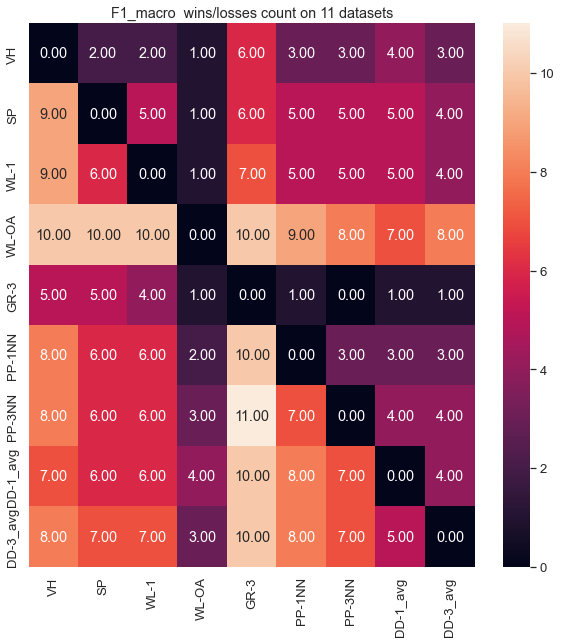

In [72]:
with sns.plotting_context(context='notebook', font_scale=1.2):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    sns.heatmap(pd.DataFrame((wins_score / 2), columns = model_names, index=model_names), ax=ax, annot=True, fmt='.2f')
    plt.title(f'{score_metric}  wins/losses count on {len(wanted_dataset_names)} datasets')

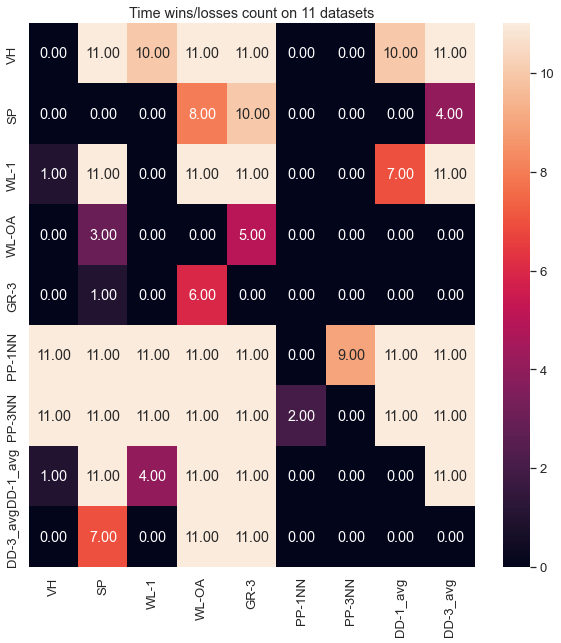

In [73]:
with sns.plotting_context(context='notebook', font_scale=1.2):
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    sns.heatmap(pd.DataFrame((wins_time / 2) , columns = model_names, index=model_names), ax=ax, annot=True, fmt='.2f')
    plt.title(f'Time wins/losses count on {len(wanted_dataset_names)} datasets')

In [ ]:
# melted = res.melt(id_vars=['Dataset', 'Model'], value_vars=['Acc', 'Acc_std', 'F1', "F1_std", 'Time'])
# with sns.plotting_context(context='notebook', font_scale=1.5):
#     #fig, ax = plt.subplots(1, 1, figsize=(20,10))
#     g = sns.catplot(x="variable", y="value", col="Dataset", hue='Model', sharey=False, col_wrap=4,
#                 data=melted, saturation=.5,
#                 kind="bar", ci=None, aspect=.6)

In [ ]:
res['dataset_rank'] = res.groupby(['Dataset'])['F1_macro'].rank(ascending=False)
res.groupby('Model').mean().sort_values('dataset_rank')

In [ ]:
import plotly.express as px
fig = px.scatter(res[res['Dataset']=='AIDS'], x="Time", y="F1_macro", color="Model",
                  hover_data=['Model', 'Dataset', 'F1_macro', 'Time', 'Acc'])
fig.show()

In [ ]:
print(np.log(50))
print(np.log(3) + np.log(5) + np.log(3) + np.log(5))
print(np.log(3) + np.log(3) + np.log(7) + np.log(3))

In [ ]:
model_names = sorted(res['Model'].unique())

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=4, start_cell="top-left")
for index, dataset_name in enumerate(wanted_dataset_names):
    subset = res[res['Dataset'] ==dataset_name]
    row = int((index + 1) / 4) + 1
    col = ((index) % 4) +1
    fig.add_trace(go.Scatter(x=subset['Time'], y=subset["F1_macro"], mode='markers',
                             marker = dict (color=[model_names.index(model_) for model_ in subset["Model"]])),
                  row=row, col=col,)

fig.show()

In [ ]:
(index) % 4

In [ ]:
pd.DataFrame(results)

In [ ]:
prime_adj_train[1230]

In [ ]:
len(G_train), K_train.shape

In [ ]:

pp.transform([prime_adj_train[1229]])

In [ ]:
prime_adj_train[1229].shape[0]

In [ ]:
import networkx as nx
path = "/Users/Konstantinos.Bougiatiotis@ey.com/Downloads/LINUX/train/"
G = nx.read_gexf(path+"0.gexf")
type(G)

In [ ]:
G.edges(data=True)

In [ ]:
res[res['Dataset'] == 'PTC_MR']


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
dataset = fetch_dataset('PTC_MR', verbose=False, download_if_missing=True)
G, y = dataset.data, dataset.target
prime_adj_all = [get_prime_adjacency(g[2]) for g in  G]

from sklearn.model_selection import StratifiedKFold, GridSearchCV
param_grid = {'C': [10**p for p in [-3, -2, -1, 0, 1, 2, 3]],
              'kernel': ['rbf', 'linear', 'sigmoid']}
cv = StratifiedKFold(random_state=None, n_splits=10)
prime_adj_all_array = np.array(prime_adj_all, dtype='object')
acc = []
f1 = []
for train_indices, test_indices in cv.split(prime_adj_all, y):
    pp = ProductPower(power=1, normalize=True, grakel_compatible=False, kernel='rbf')
    X_train = prime_adj_all_array[train_indices]
    y_train = y[train_indices]
    X_test = prime_adj_all_array[test_indices]
    y_test = y[test_indices]
    X_train = pp.fit_transform(X_train, y_train)
    X_test = pp.transform(X_test)
    param_grid = {'C': [10**p for p in [-3, -2, -1, 0, 1, 2, 3]],
    grid = GridSearchCV(SVC(), param_grid, refit = True, cv=10, verbose = 0, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_, grid.best_score_)
    y_pred = grid.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    print(f'Acc: {acc[-1]:.2f}, F1: {f1[-1]:.2f}')
    print('~'*50)
print(f'Acc: {100 * np.mean(acc):.2f} % ({np.std(acc):.2f})')
print(f'F1: {100 * np.mean(f1):.2f} % ({np.std(f1):.2f})')

In [ ]:
print(f'Acc: {100 * np.mean(acc):.2f} % ({np.std(acc):.2f})')
print(f'F1: {100 * np.mean(f1):.2f} % ({np.std(f1):.2f})')

# Work on Node classificaton IMDB multi-relational
https://www.ijcai.org/proceedings/2020/0175.pdf

THESE DID NOT WORK FOR IMDB, ACM, DBLP because of very trivial form of the datasets.
IMDB has two relations. Each node has exactly 1 r1 and 2 r2 to different nodes. So their product will be the same for all nodes.

Also, for all 3 datasets the 2-hop adjacency is all zeros (seems like disconeccted cases)


In [ ]:
from scipy.sparse import csr_matrix, csc_matrix
def generate_prime_adj(data, wanted_indexes):

    rels = sorted(wanted_indexes)
    from sympy import nextprime
    relid2prime = {}
    prime2relid = {}
    current_int = 2
    for rel in rels:
        cur_prime = int(nextprime(current_int))
        relid2prime[rel] = cur_prime
        prime2relid[cur_prime] = rel
        current_int = cur_prime

    data_edges, rows, cols = [], [], []
    for rel_index in rels:
        #print(rel_index, len(data))

        rel_graph = data[rel_index]
        print(rel_graph.nnz)
        rows_ar, cols_ar = rel_graph.nonzero()
        rows.extend(rows_ar.tolist())
        cols.extend(cols_ar.tolist())
        data_edges.extend([relid2prime[rel_index] for _ in cols_ar])
    return csc_matrix((data_edges, (rows, cols)), dtype=int, shape=rel_graph.shape)


In [ ]:
import pickle

In [ ]:
# FOR IMDB we have 4 relation graphs. Rel graphs 0,1 are symmetric of each other and the same stands for 2,3.
# 0,1 correspond to relation 0 and 2,3 to relation 2.


path_edges = "/Users/Konstantinos.Bougiatiotis@ey.com/Downloads/data/DBLP/edges.pkl"
path_labels = "/Users/Konstantinos.Bougiatiotis@ey.com/Downloads/data/DBLP/labels.pkl"
with open(path_edges, 'rb') as f:
    data = pickle.load(f)
    print(f'Number of edge graphs {len(data)}')
    wanted_indexes = [0, 2]
    adj_ = generate_prime_adj(data, wanted_indexes).toarray()


node2label = np.zeros(adj_.shape[0]) - 1
node_splits = {}
with open(path_labels, 'rb') as f:
    data = pickle.load(f)
    for i, d in enumerate(data):
        unzipped = [item for item in  zip(*d)]
        node2label[np.array(unzipped[0])] = unzipped[1]
        if i == 0:
            case = 'train'
        elif i == 1:
            case = 'eval'
        else:
            case = 'test'
        cur_indexes = np.array(unzipped[0])
        cur_indexes.sort()
        print(f'Case: {case} | # of nodes: {len(cur_indexes)}')
        node_splits[case] = cur_indexes

In [ ]:
cur_feat = []
                cur_x = x.copy()
                # Power = 0 (1-hop, original Adjacency)
                cur_prod = np.sum(np.log(cur_x[cur_x >0]))

                if self.normalize:
                    cur_prod = cur_prod / ((n**2)*np.log(self.max_))
                cur_feat.append(cur_prod)
                for p in range(1, self.power):
                    cur_x = np.matmul(cur_x, x)
                    cur_prod = np.sum(np.log(cur_x[cur_x >0]))
                    if self.normalize:
                        cur_prod = cur_prod / ((n**2)*np.log(self.max_**p))
                    cur_prod -= cur_feat[-1]
                    cur_feat.append(cur_prod)
                x_tr.append(np.array(cur_feat))

In [ ]:
class PrimeNodeTransfomer(TransformerMixin):

    def __init__(self, power=1):
        self.power = power

    def fit(self, X, y, adj):
        return self

    def fit_transform(self, X, y, adj):
        self.fit(X, y, adj)
        return self.transform(X=X, adj=adj)


    def transform(self, X, adj):
        cur_feat = []
        for p in range(0, self.power):
            if p == 0:
                cur_x = adj.copy()
            else:
                cur_x = np.multiply(cur_x, adj)
            print(p)
            cur_x_ones = cur_x.copy()
            print('copy')
            cur_x_ones[cur_x_ones == 0] = 1
            print('ones')
            vals = np.log(cur_x_ones).sum(axis=1)[X]
            print('log-sum')
            cur_feat.append(vals)
        return np.vstack(cur_feat)

pnt = PrimeNodeTransfomer(power=1)
pnt.fit_transform(node_splits['test'], node2label[node_splits['test']], adj_)

In [ ]:
adj_.sum()

In [ ]:
adj_2 = adj_ @ adj_
cop = adj_2[node_splits['eval'],:].copy()
cop.data = np.log(cop.data)
cop.sum(axis=1)

In [ ]:
adj2_dense = np.multiply(adj_.todense(), adj_.todense())

In [ ]:
adj2_dense[node_splits['train']]

In [ ]:
cop[10].nonzero(), cop[10].data

In [ ]:
cop[1].nonzero(), cop[1].data

In [ ]:
data[1][4661].nonzero()

In [ ]:
(data[2]!=data[3].T).nnz == 0

In [ ]:
np.argsort(adj_.sum(axis=1).flatten())[::-1]

In [ ]:
c = adj_.sum(axis=1).toarray()


In [ ]:
_, cols = adj_[17558].nonzero()

In [ ]:
for c in cols:
    print(c, adj_[c].nnz)

In [ ]:
from grakel.datasets.base import dataset_metadata

# We want edge labels as these are the multi-relational
# We need node labels for the other methodologies
# Tox datasets seem to have problems
wanted_dataset_names = []
for dataset_name, values in dataset_metadata.items():
    if values['el'] and values['nl'] and not('Tox' in dataset_name):
        wanted_dataset_names.append(dataset_name)

# Tox21_AHR has an empty graph,
# Tox21_AR is wronly packaged (the downloaded file after unzipping is named something else and throws error
# Cuneiform soemthing wrong with the node labels being strings instead of ints?
# Zinc and Alchemy do not have graph labels. Maybe need to download train,test,valid
unwanted = set(['Cuneiform', 'Tox21_AHR', 'Tox21_AR', 'ZINC_full', 'alchemy_full', 'MOLT-4', 'MCF-7', 'YEAST'])
extra_wanted = ['MOLT-4', 'YEAST']
for dataset_name in extra_wanted:
   dataset_metadata[dataset_name] = {'el':True, 'nl':True}

wanted_dataset_names =[dt for dt in wanted_dataset_names if not(dt in unwanted)]
wanted_dataset_names = extra_wanted + wanted_dataset_names

#wanted_dataset_names = extra_wanted
print(f'Total: {len(wanted_dataset_names)} datasets')
for dt in wanted_dataset_names:
    print(dt)

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import time
from grakel.kernels import WeisfeilerLehman, VertexHistogram, WeisfeilerLehmanOptimalAssignment, GraphletSampling, EdgeHistogram
from sklearn.metrics import f1_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


import time
from grakel.kernels import WeisfeilerLehman, VertexHistogram, WeisfeilerLehmanOptimalAssignment, GraphletSampling
from sklearn.metrics import f1_score, accuracy_score

from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

models = [
#    VertexHistogram(normalize=True),
    # ShortestPath(normalize=True),
    # WeisfeilerLehman(n_iter=1, base_graph_kernel=VertexHistogram, normalize=True),
    # WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True),
    # WeisfeilerLehmanOptimalAssignment(n_jobs=-1, n_iter=3),
    # GraphletSampling(n_jobs=-1, k=3),
    ProductPower(power=1, normalize=False, grakel_compatible=False),
    ProductPower(power=3, normalize=False, grakel_compatible=False),
    Decomposer(power=1, n_components='average', grakel_compatible=False),
    Decomposer(power=3, n_components='average', grakel_compatible=False),
    #Decomposer(power=5, n_components='average', grakel_compatible=False),
    #ProductPower(power=5, grakel_compatible=False),
    #ProductPower(power=10, grakel_compatible=False),
]

model_names = [
#    'VH',
    # 'SP',
    # 'WL-1',
    # 'WL-4',
    # 'WL-OA',
    # 'GR-3',
    'PP-1NN',
    'PP-3NN',
   'DD-1_avg',
   'DD-3_avg',
 #   'DD-5_avg',
    # 'PP-5',
    # 'PP-10',
]

cv = StratifiedKFold(random_state=None, n_splits=10)
results = []
for dataset_name in wanted_dataset_names[:]:
    print(f'Dataset: {dataset_name}')
    if dataset_name in extra_wanted:
        dataset = read_wrapper(name=dataset_name)
    else:
        dataset = fetch_dataset(dataset_name, verbose=False, download_if_missing=True)
    G, y = dataset.data, dataset.target
    print(len(G))
    prime_adj_all = [get_prime_adjacency(g[2]) for g in  G]
    print(f'Parsed {dataset_name}')
    # Splits the dataset into a training and a test set
    for fold_index, (train_indices, test_indices) in enumerate(cv.split(G, y)):
        for model, model_name in zip(models, model_names):
            print(model_name)
            #print(model_name)
            time_s = time.time()
            if 'PP' in model_name or 'DD' in model_name:
                if dataset_name in extra_wanted:
                    clf = LinearSVC(dual=False, class_weight='balanced')
                else:
                    clf = SVC(kernel="rbf", class_weight='balanced')
                pipe = Pipeline([
                 ('tr', model),
                ('sd', StandardScaler()),
                ('clf', clf)
                ])
                X = np.array(prime_adj_all)
            else:
                if dataset_name in extra_wanted:
                    clf = SVC(kernel='precomputed', class_weight='balanced', dual=False)
                else:
                    clf = SVC(kernel="precomputed", class_weight='balanced')
                pipe = Pipeline([
                ('tr', model),
                #('sd', StandardScaler()),
                ('clf', clf)
                ])
                X = np.array(G)
            X_train, y_train = X[train_indices], y[train_indices]
            X_test, y_test = X[test_indices], y[test_indices]
            param_grid = {'clf__C': [10**p for p in [-3, -2, -1, 0, 1, 2, 3]]}
            grid = GridSearchCV(pipe, param_grid, refit = True, cv=10, verbose = 0, n_jobs=-1)
            grid.fit(X_train, y_train)
            #print(grid.best_params_, grid.best_score_)
            y_pred = grid.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1_pos = f1_score(y_test, y_pred, average='binary')
            f1_macro = f1_score(y_test, y_pred, average='macro')
            time_took = time.time() - time_s
            results.append({'Dataset':dataset_name,
                            'Fold':fold_index,
                            'Model':model_name,
                            'Acc':acc,
                            'F1_macro':f1_macro,
                            'F1_pos':f1_pos,
                            'Time':time_took})
            m = pd.DataFrame([results[-1]])
            print(f'Model: {model_name}  Dataset: {dataset_name} Fold:{fold_index}  F1: {m["F1_macro"].mean():.2f} Time: {m["Time"].mean():.4f}')
    print('~'*20)

In [ ]:
res = pd.DataFrame(results)
res.to_csv("./results/gridsearch_PPDD_all.csv", index=False)

In [17]:
res.groupby(["Dataset", "Model"])[['F1_macro', 'Acc', 'Time']].mean()

F1_macro       Acc       Time
Dataset      Model                                
AIDS         PP-1NN  0.992840  0.995500   5.635735
             PP-3NN  0.992080  0.995000   5.921503
BZR_MD       PP-1NN  0.606356  0.631075   0.744635
             PP-3NN  0.563167  0.584301   0.723169
COX2_MD      PP-1NN  0.339972  0.442796   0.791857
             PP-3NN  0.397362  0.452688   0.809806
DHFR_MD      PP-1NN  0.359532  0.579423   1.039707
             PP-3NN  0.359532  0.579423   0.972583
ER_MD        PP-1NN  0.658036  0.665202   1.357107
             PP-3NN  0.655223  0.663030   1.333684
MUTAG        PP-1NN  0.827798  0.839766   0.542717
             PP-3NN  0.843852  0.855848   0.543900
Mutagenicity PP-1NN  0.598875  0.601338  26.137592
             PP-3NN  0.646295  0.648365  22.186314
PTC_FM       PP-1NN  0.462781  0.584538   0.763889
             PP-3NN  0.438728  0.581681   0.748424
PTC_FR       PP-1NN  0.321052  0.409603   0.747988
             PP-3NN  0.268770  0.372460   0.759703
PTC_MM       PP-1NN  0.509061  0.542068   0.737540
             PP-3NN  0.523292  0.569162   0.741754
PTC_MR       PP-1NN  0.502476  0.554622   0.756873
             PP-3NN  0.509899  0.563445   0.756595

In [ ]:
res.groupby(["Dataset", "Model"])[['F1_macro', 'Acc', 'Time']].std()


In [53]:
df = pd.read_csv("./results/res_small_all.csv", header=0)
df.head()

,Dataset,Model,Acc,Acc_std,F1_macro,F1_macro_std,F1_micro,F1_micro_std,Time,dataset_rank
0,AIDS,VH,0.5670,0.025904,0.553577,0.022923,0.5670,0.025904,2.153913,9.0
1,AIDS,SP,0.9875,0.007159,0.980718,0.011020,0.9875,0.007159,3.937881,7.0
2,AIDS,WL-1,0.8365,0.026082,0.793473,0.028614,0.8365,0.026082,0.694691,8.0
3,AIDS,WL-OA,0.9935,0.004500,0.989670,0.007227,0.9935,0.004500,128.351545,5.0
4,AIDS,GR-3,0.9890,0.004359,0.982807,0.006920,0.9890,0.004359,3.897159,6.0


In [16]:
df.groupby(['Model'])[['Acc', 'F1_macro', 'F1_micro', 'Time', 'dataset_rank']].median().sort_values('dataset_rank')

,Acc,F1_macro,F1_micro,Time,dataset_rank
Model,,,,,
WL-OA,0.631640,0.609073,0.631640,1.424161,2.0
DD-1_avg,0.621218,0.592575,0.621218,0.217607,4.0
DD-3_avg,0.618718,0.590554,0.618718,0.538012,5.0
PP-3NN,0.582628,0.552988,0.582628,0.046070,5.0
PP-1NN,0.582628,0.552988,0.582628,0.042529,6.0
WL-1,0.632619,0.547443,0.632619,0.216620,6.0
SP,0.578384,0.557314,0.578384,1.387981,7.0
VH,0.578487,0.516811,0.578487,0.056414,8.0
GR-3,0.579857,0.452344,0.579857,3.897159,9.0


In [20]:
melted = df.melt(id_vars=['Dataset', 'Model'], value_vars=['Acc'])
melted

,Dataset,Model,variable,value
0,AIDS,VH,Acc,0.567000
1,AIDS,SP,Acc,0.987500
2,AIDS,WL-1,Acc,0.836500
3,AIDS,WL-OA,Acc,0.993500
4,AIDS,GR-3,Acc,0.989000
...,...,...,...,...
94,PTC_MR,GR-3,Acc,0.493950
95,PTC_MR,PP-1NN,Acc,0.552353
96,PTC_MR,PP-3NN,Acc,0.558487
97,PTC_MR,DD-1_avg,Acc,0.575378


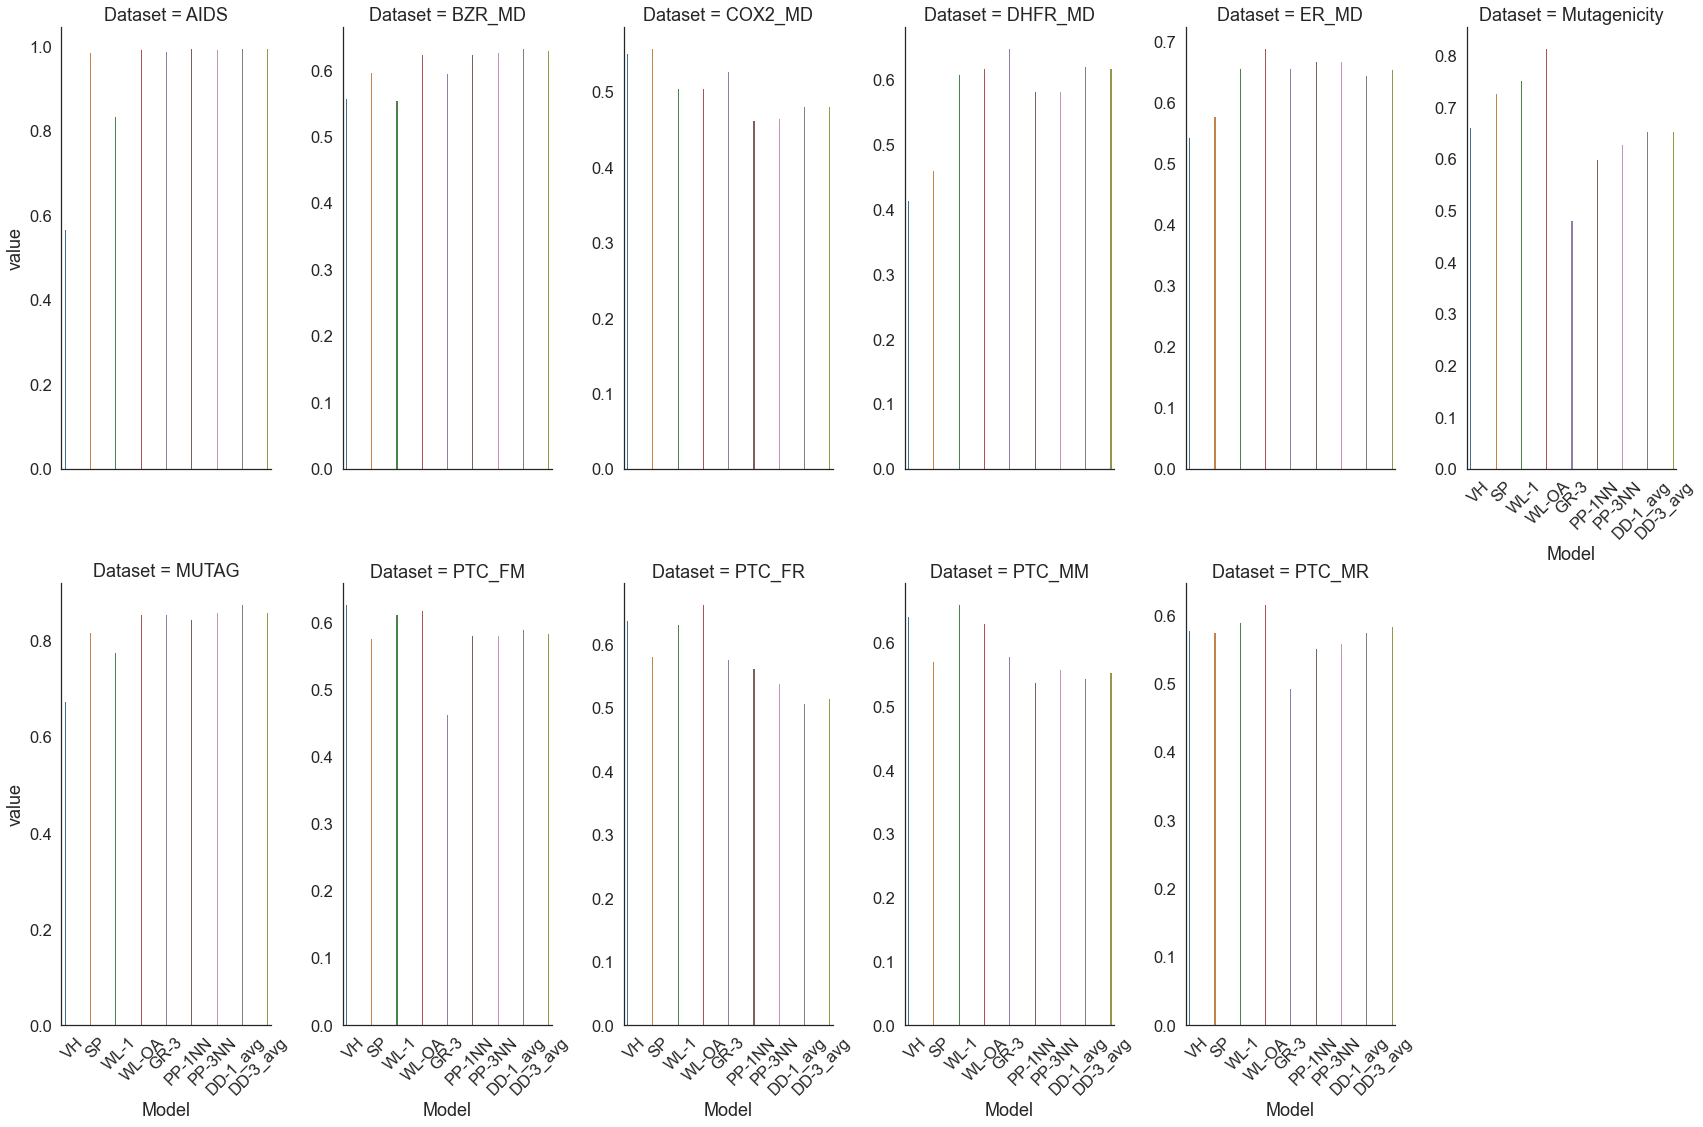

In [23]:
with sns.plotting_context(context='notebook', font_scale=1.5):
    #fig, ax = plt.subplots(1, 1, figsize=(20,10))
    g = sns.catplot(x="Model", y="value", col="Dataset", hue="Model", sharey=False, col_wrap=6,
                data=melted, saturation=.5, height=8,
                kind="bar", ci=None, aspect=0.5)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    plt.tight_layout()

In [30]:
df.set_index('Model').groupby('Dataset')[['Acc', 'Time']].mean()

,Acc,Time
Dataset,,
AIDS,0.928611,15.933086
BZR_MD,0.605066,8.120859
COX2_MD,0.504313,18.644810
DHFR_MD,0.572870,28.540923
ER_MD,0.639719,20.608274
MUTAG,0.825211,0.196822
Mutagenicity,0.664026,68.124723
PTC_FM,0.581886,0.387928
PTC_FR,0.579559,0.399657


In [58]:
pivoted_time = df.pivot(index='Model', columns='Dataset', values='Time')
pivoted_time.reindex(df.Model.unique().tolist())

Dataset,AIDS,BZR_MD,COX2_MD,DHFR_MD,ER_MD,MUTAG,Mutagenicity,PTC_FM,PTC_FR,PTC_MM,PTC_MR
Model,,,,,,,,,,,
VH,2.153913,0.047803,0.061072,0.189571,0.200573,0.050682,2.466931,0.056414,0.053151,0.050331,0.051458
SP,3.937881,1.387981,2.154609,2.335693,2.205939,0.327858,21.339151,0.450603,0.479083,0.438009,0.462228
WL-1,0.694691,0.216620,0.294610,0.424111,0.410505,0.069230,3.202523,0.084095,0.083257,0.076558,0.079512
WL-OA,128.351545,1.295443,1.368300,2.066129,2.291179,0.409428,541.491803,1.424161,1.442516,1.295198,1.365047
GR-3,3.897159,69.440124,163.151339,250.893337,179.185509,0.462833,23.939787,0.638295,0.678561,0.592067,0.679877
PP-1NN,0.087555,0.039143,0.042529,0.065069,0.066449,0.027025,1.736514,0.040933,0.044925,0.037976,0.038196
PP-3NN,0.117171,0.043183,0.040414,0.045431,0.068550,0.029699,1.871982,0.046640,0.046946,0.043183,0.046070
DD-1_avg,1.149901,0.176883,0.198671,0.236716,0.309848,0.107627,5.063207,0.212201,0.226346,0.210069,0.217607
DD-3_avg,3.007963,0.440554,0.491750,0.612247,0.735915,0.287014,12.010611,0.538012,0.542126,0.517979,0.536219


In [75]:
pivoted_time = df.pivot(index='Model', columns='Dataset', values='F1_macro')
pivoted_time.reindex(df.Model.unique().tolist())

Dataset,AIDS,BZR_MD,COX2_MD,DHFR_MD,ER_MD,MUTAG,Mutagenicity,PTC_FM,PTC_FR,PTC_MM,PTC_MR
Model,,,,,,,,,,,
VH,0.553577,0.496475,0.516811,0.375272,0.504458,0.627237,0.656561,0.529344,0.455480,0.572401,0.433788
SP,0.980718,0.580443,0.526660,0.436272,0.552092,0.793302,0.725739,0.524760,0.515973,0.557314,0.558059
WL-1,0.793473,0.487860,0.472660,0.490553,0.632602,0.766530,0.752087,0.547443,0.532620,0.611438,0.536189
WL-OA,0.989670,0.595977,0.482657,0.561891,0.684462,0.836512,0.812835,0.593701,0.611989,0.599425,0.609073
GR-3,0.982807,0.584255,0.428382,0.445011,0.645779,0.844886,0.392199,0.452344,0.378704,0.456394,0.420520
PP-1NN,0.992840,0.599883,0.450847,0.552988,0.660157,0.833358,0.595220,0.540008,0.515924,0.517035,0.540333
PP-3NN,0.991306,0.606705,0.452003,0.552988,0.660123,0.849698,0.628647,0.540299,0.499807,0.544088,0.546420
DD-1_avg,0.995237,0.597765,0.462099,0.592575,0.632524,0.867801,0.652372,0.561964,0.452611,0.520842,0.552721
DD-3_avg,0.995237,0.594729,0.462099,0.590554,0.643839,0.852207,0.653237,0.558790,0.478253,0.536996,0.563088


/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


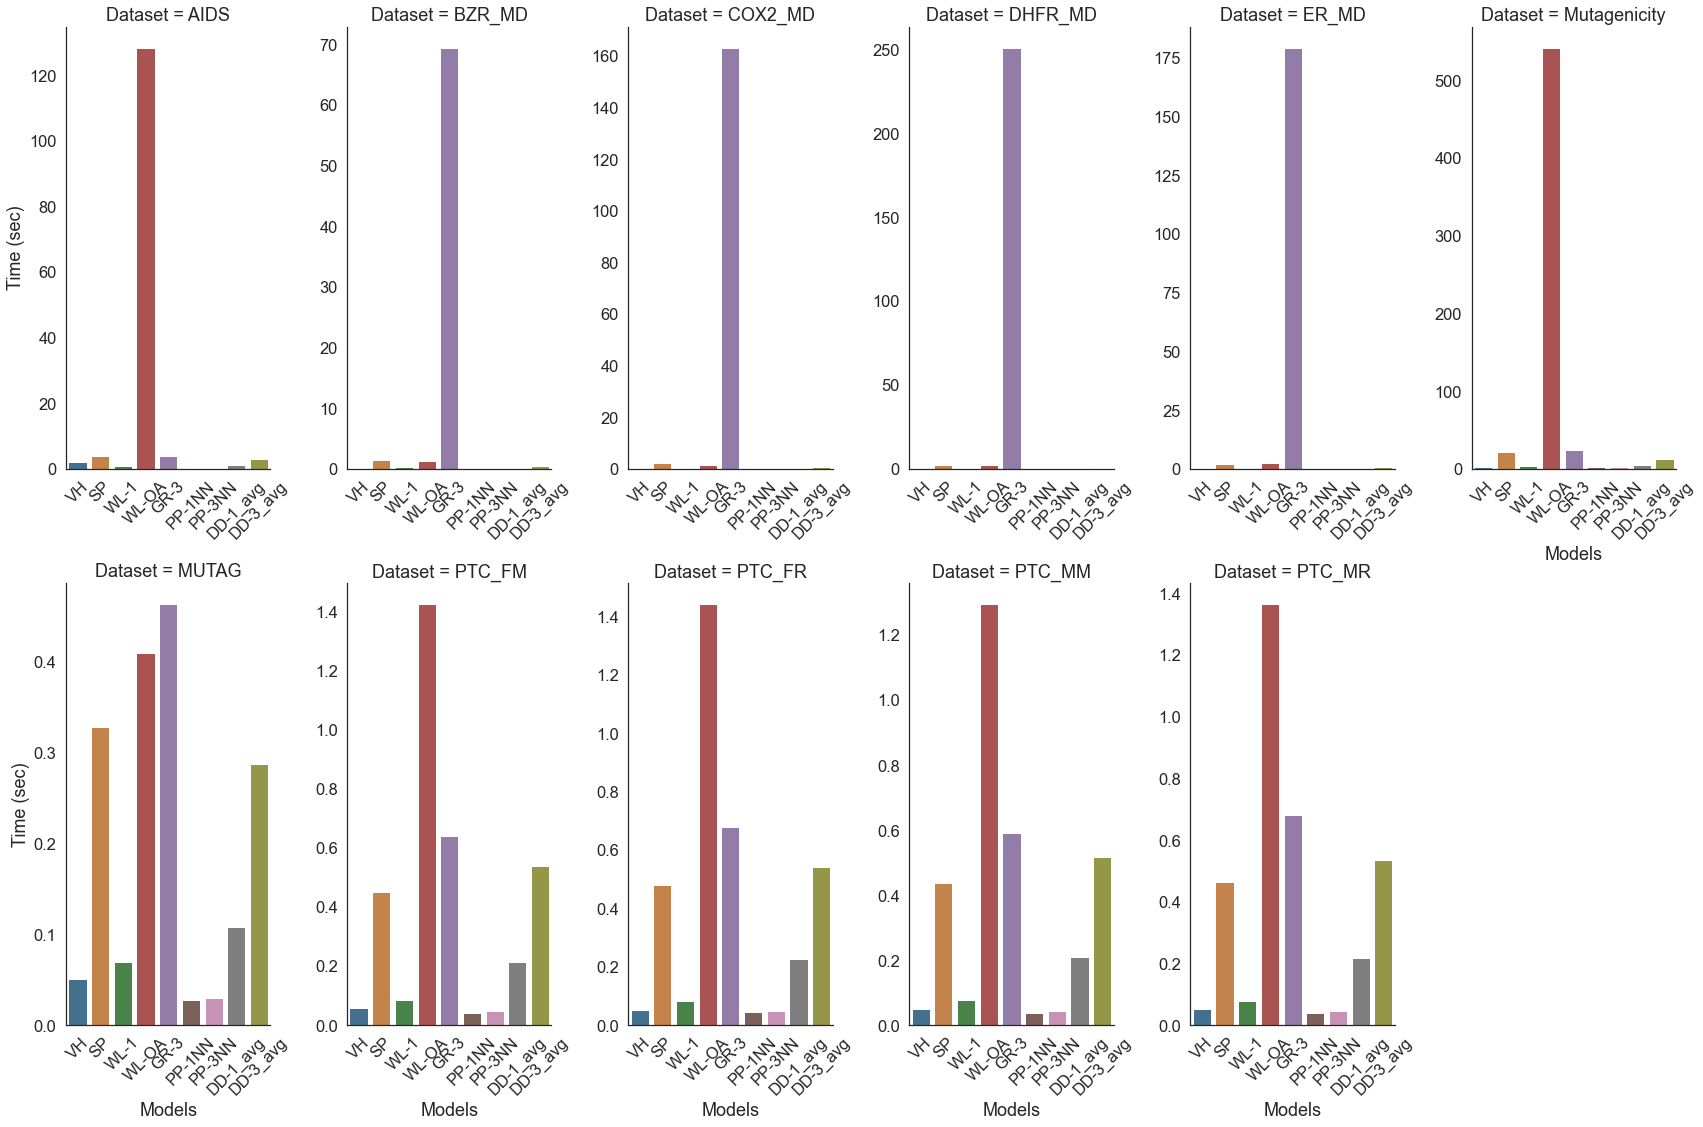

In [66]:
melted = df.melt(id_vars=['Dataset', 'Model'], value_vars='Time')
with sns.plotting_context(context='notebook', font_scale=1.5):
    #fig, ax = plt.subplots(1, 1, figsize=(20,10))
    g = sns.catplot(x="Model", y="value", col="Dataset", sharey=False, col_wrap=6, sharex=False,
                data=melted, saturation=.5, height=8,
                kind="bar", ci=None, aspect=0.5)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    plt.tight_layout()
    (g.set_axis_labels("Models", "Time (sec)"))

/Users/Konstantinos.Bougiatiotis@ey.com/anaconda3/envs/lola/lib/python3.7/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


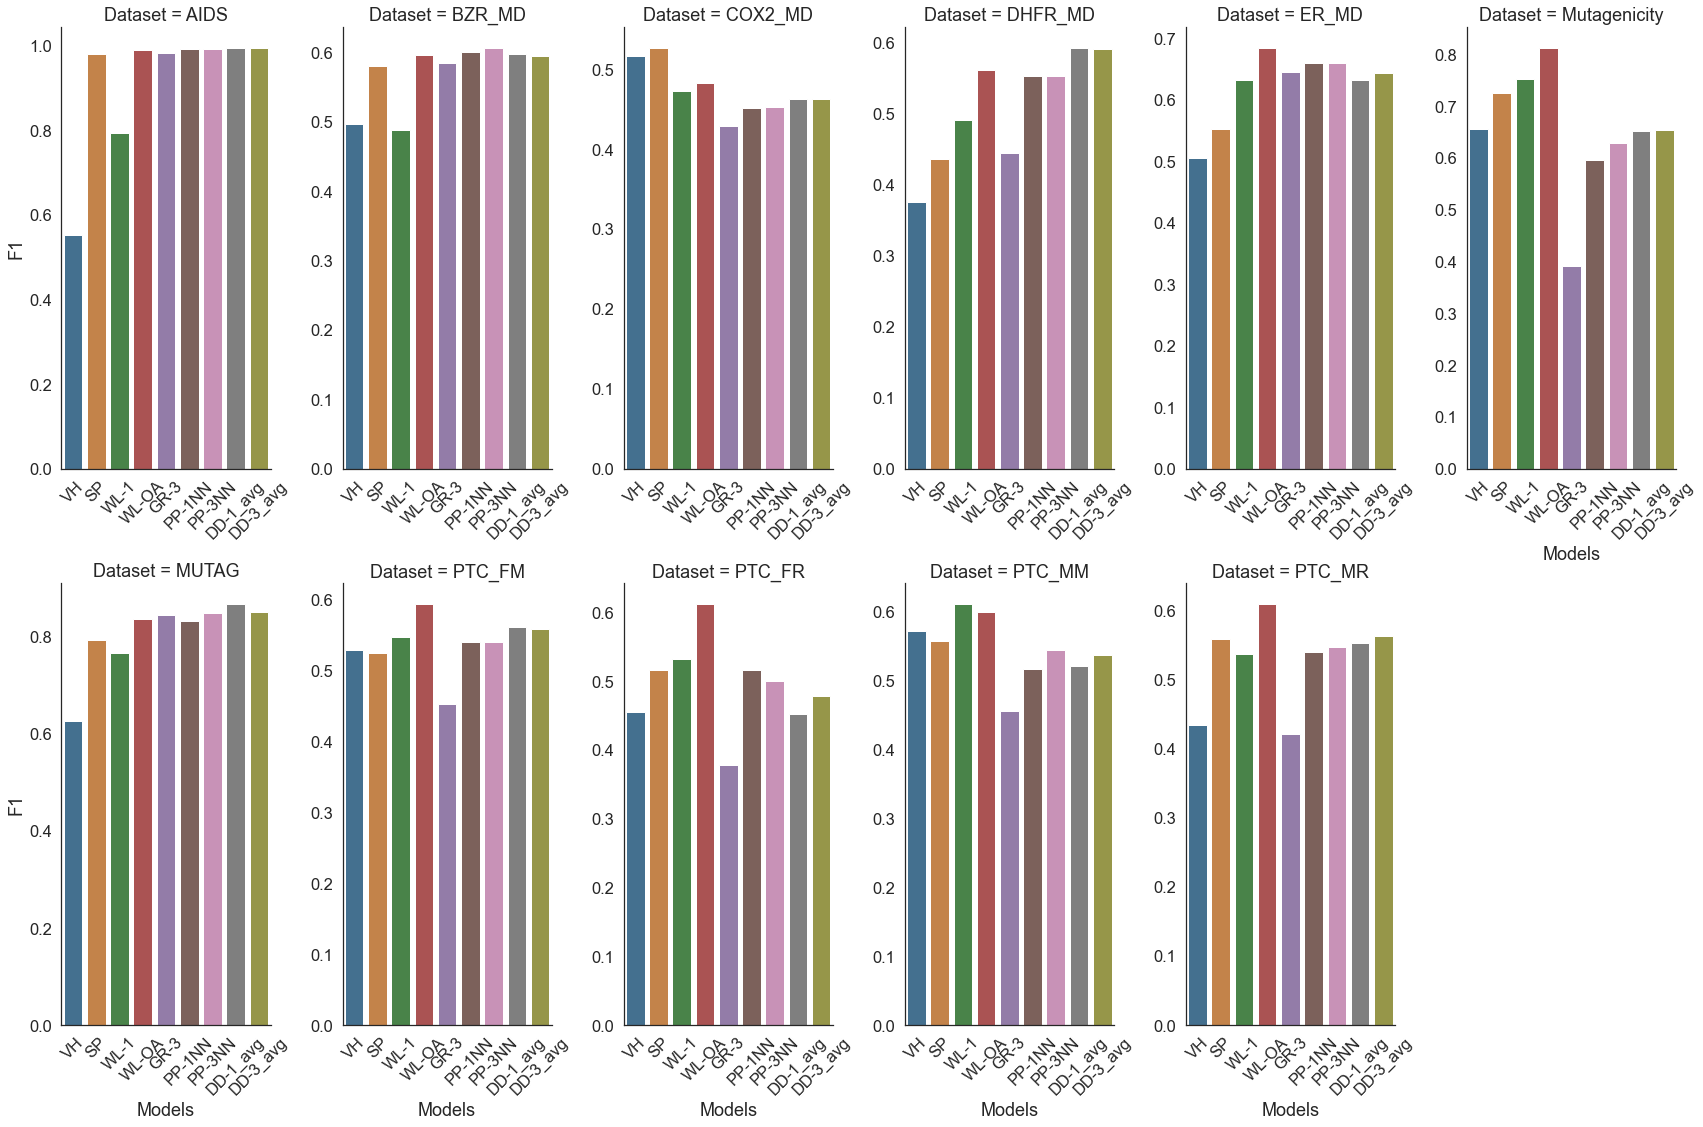

In [74]:
melted = df.melt(id_vars=['Dataset', 'Model'], value_vars='F1_macro')
with sns.plotting_context(context='notebook', font_scale=1.5):
    #fig, ax = plt.subplots(1, 1, figsize=(20,10))
    g = sns.catplot(x="Model", y="value", col="Dataset", sharey=False, col_wrap=6, sharex=False,
                data=melted, saturation=.5, height=8,
                kind="bar", ci=None, aspect=0.5)
    for axes in g.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    plt.tight_layout()
    (g.set_axis_labels("Models", "F1"))